# prototyping machine learning project from Dermnet dataset
this note book use for make prototype model to deterrmine the best model architecture. dataset that using from kaggle.com 
this notebook design for running in google colab.

### description of dataset 
- 

### purpose of the notebook
-

## Install  package
- ensure that you was isntall these package. if you not intall these package yet, feel free to uncomment and execute cell below

In [ ]:
#!pip install matplotlib
#!pip install PIL
#!pip install SciPy
#!pip install sklearn
#!pip install tensorflow
#!pip install numpy
#!pip install kaggle

## download dataset
- we are already download this dataset. if you not dowload yet uncomment and execute code below. you may have to upload your kaggle.json first

In [ ]:
#!cp ~/content/kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json
## copy API download dataset command  di dataset kagle, kemudian paste di sini
#!kaggle datasets download -d shubhamgoel27/dermnet

In [ ]:
# alternative dataset
#!kaggle datasets download -d paoloripamonti/derma-diseases
#https://www.kaggle.com/datasets/paoloripamonti/derma-diseases

## import libraries 

In [ ]:
# libraries for extract and pre precessing data
import os, zipfile, PIL,shutil
# libraries for machine learning model
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.optimizers import RMSprop, Adam
#libraries for preprocessing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import heapq
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
#libraries for plotting
import numpy as np
import matplotlib.pyplot as plt
# libraries for save data
import datetime


## extract dataset and split it into train and test 
dermnet.zip already  split into train and test directoy, so it just need to extract

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#local_zip = "/content/drive/MyDrive/new_dataset.zip"
#extract_dir = "/content/drive/MyDrive/new_dataset"
#zip_ref = zipfile.ZipFile(local_zip, 'r')
#zip_ref.extractall(extract_dir)
#zip_ref.close()

train_dir= os.path.join("/content/drive/MyDrive/new_dataset/new_dataset","train")
test_dir= os.path.join("/content/drive/MyDrive/new_dataset/new_dataset","test")

# data and image exploration
to explore feature of the image 

In [ ]:
# train, test, and number sample each label exploration
labels= os.listdir(train_dir)
test_label=os.listdir(test_dir)
for label in labels:
    if label not in test_label:
        shutil.rmtree(os.path.join(train_dir,label))
labels= os.listdir(train_dir)
for label in labels:
    if len(os.listdir(os.path.join(train_dir,label))) < 100:
        shutil.rmtree(os.path.join(train_dir,label))
        shutil.rmtree(os.path.join(test_dir,label))
labels= os.listdir(train_dir)
print(" the model has {} labels with is \n".format(len(labels)))
for nomor, label in enumerate(labels):
    print("{} {} have {} train data samples and {} test data samples".format(nomor, 
                                                                             label, 
                                                                             len(os.listdir(os.path.join(train_dir,label))),
                                                                             len(os.listdir(os.path.join(test_dir,label)))
                                                                            )
         )
# image exploration

image_sample_dir=[os.path.join(train_dir,label) for label in labels[:5]]
for dir_ in image_sample_dir:
    for img in os.listdir(dir_)[:2]:
        im= PIL.Image.open(os.path.join(dir_, img))# pass with the picture directory
        print("image \n format :{},size: {} , color: {} \n".format(im.format,im.size,im.mode))


 the model has 15 labels with is 

0 acne-cystic have 120 train data samples and 39 test data samples
1 basal-cell-carcinoma-lesion have 105 train data samples and 24 test data samples
2 dermatofibroma have 103 train data samples and 34 test data samples
3 distal-subungual-onychomycosis have 105 train data samples and 21 test data samples
4 eczema-fingertips have 112 train data samples and 30 test data samples
5 eczema-hand have 102 train data samples and 20 test data samples
6 eczema-nummular have 104 train data samples and 24 test data samples
7 herpes-zoster have 103 train data samples and 29 test data samples
8 lichen-planus have 101 train data samples and 22 test data samples
9 perioral-dermatitis have 109 train data samples and 51 test data samples
10 psoriasis have 103 train data samples and 20 test data samples
11 rosacea have 178 train data samples and 71 test data samples
12 seborrheic-keratoses-ruff have 105 train data samples and 25 test data samples
13 seborrheic-keratosis

In [ ]:
len(labels)

15

In [ ]:
def generate_class_weights(class_series):
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))

## preprocessing data
it will process the raw data so that can use for data training. we will use class ImageDataGenerator and flow_from_directory() method. and include augmentation( rescale, sheer, zoom, etc)

Found 1652 images belonging to 15 classes.
Found 1652 images belonging to 15 classes.
(64, 224, 224, 3)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


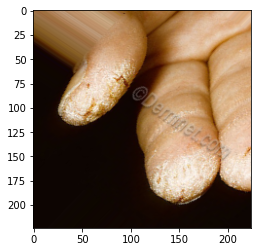

(64, 224, 224, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


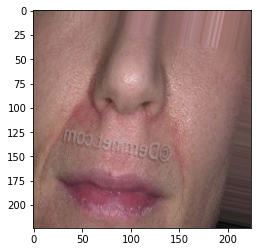

(64, 224, 224, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


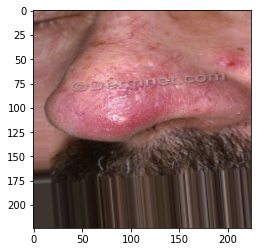

(64, 224, 224, 3)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


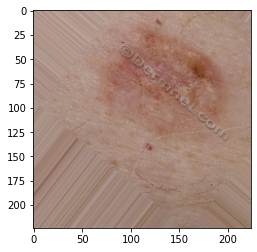

(64, 224, 224, 3)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


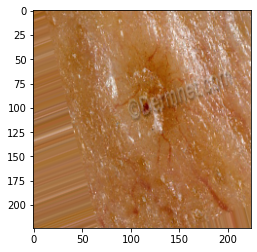

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = 224 # be wise to set this value
train_datagen=ImageDataGenerator(rescale=1/255,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode="nearest"
                                )
train_generator=train_datagen.flow_from_directory(train_dir,
                                                  target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                  class_mode="categorical",#edit disini)
                                                  batch_size=BATCH_SIZE
                                                 )

test_datagen=ImageDataGenerator(rescale=1/255)
test_generator= test_datagen.flow_from_directory( train_dir,
                                                  target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                  class_mode="categorical",#edit disini)
                                                  batch_size=BATCH_SIZE
                                                )
#ploting versi image generator
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    print(label[0])
    plt.imshow(img[0])
    plt.show()

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    shuffle = True,
                                                                    image_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                                    batch_size = BATCH_SIZE 
                                                                   )
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                   shuffle = True,
                                                                   image_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                                   batch_size = BATCH_SIZE  
                                                                  )
print(train_dataset)
#class names pakek image generator
class_names = train_generator.class_indices
print(class_names)

Found 1652 files belonging to 15 classes.
Found 462 files belonging to 15 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
{'acne-cystic': 0, 'basal-cell-carcinoma-lesion': 1, 'dermatofibroma': 2, 'distal-subungual-onychomycosis': 3, 'eczema-fingertips': 4, 'eczema-hand': 5, 'eczema-nummular': 6, 'herpes-zoster': 7, 'lichen-planus': 8, 'perioral-dermatitis': 9, 'psoriasis': 10, 'rosacea': 11, 'seborrheic-keratoses-ruff': 12, 'seborrheic-keratosis-irritated': 13, 'stasis-dermatitis': 14}


TypeError: Tensor is unhashable. Instead, use tensor.ref() as the key.

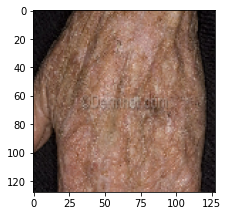

In [ ]:
plt.figure(figsize = (15,15))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]],fontsize = 8)
        plt.axis("off")

In [ ]:
labels = os.listdir(train_dir)
counts = [len(os.listdir(os.path.join(train_dir, label))) for label in labels]
print(len(counts))

15


In [ ]:
train_dict = dict(zip(labels, counts))
use_label = heapq.nlargest(10, train_dict, key=train_dict.get)
train_labels = [class_names[key] for key in train_dict for val in range(train_dict[key])]
class_weight = generate_class_weights(train_labels)

## build model architecture
it will make a few different model architecture and combination layers that will train then see the performance evaluation


### first option is use pretraining model using mobilenet 
- it will be powerfull tool 

In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))



Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [ ]:
# tuning model. you can freeze or un freeze some layers of model
do_fine_tuning = True # assign True for unfreeze some layers

In [31]:
feature_extractor= hub.KerasLayer(MODULE_HANDLE,
                                  input_shape=IMAGE_SIZE+(3,),
                                  output_shape=[FV_SIZE],
                                  trainable=do_fine_tuning)
model= tf.keras.Sequential([feature_extractor,
                            tf.keras.layers.Dropout(0.2),
                           tf.keras.layers.Dense(len(class_names), activation="softmax")])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 15)                19215     
                                                                 
Total params: 2,277,199
Trainable params: 2,243,087
Non-trainable params: 34,112
_________________________________________________________________


In [32]:
NUM_LAYERS = 20 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

In [33]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.Recall()])
else:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=[tf.keras.metrics.Recall()])

In [ ]:
# alternative way
# initial the base model from MobileNet model
IMAGE_SHAPE=(360,360)+(3,)
base_model=tf.keras.applications.MobileNetV2(input_tensor=tf.keras.Input(shape=IMAGE_SHAPE),
                                            include_top=False,
                                            weights="imagenet",)

# freeze the top layer in base_model
base_model.trainable= True
# Fine-tune from this layer onwards
fine_tune_at = 20

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
# build new model based on base_M0DEL
inputs= tf.keras.Input(shape=(360,360,3))
headModel = base_model.output
headModel = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = tf.keras.layers.Dropout(0.3)(headModel)
headModel = tf.keras.layers.Flatten(name="flatten")(headModel)
headModel = tf.keras.layers.Dense(128, activation="relu")(headModel)

headModel = tf.keras.layers.Dense(len(labels), activation="softmax")(headModel)


model=tf.keras.Model(base_model.input,headModel)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=["accuracy"])

### second option is made custom model from scart

In [ ]:

model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(BATCH_SIZE, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    
                                    tf.keras.layers.Conv2D(BATCH_SIZE, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    
                                    tf.keras.layers.Conv2D(BATCH_SIZE, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    
                                    # tf.keras.layers.Dropout(0.2),
                                    
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dense(len(labels), activation='softmax')
])
model.summary()
model.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.0001),metrics=["accuracy"])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 14, 14, 64)     

### model1

In [ ]:
model1=tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(224,224,3)),#edit sesuai dengan ukuran target),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   #2
                                   tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   #3
                                   tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   #4
                                   tf.keras.layers.Conv2D(128,(3,3),activation="relu"),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   #5
                                   tf.keras.layers.Conv2D(256,(3,3),activation="relu"),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   #6
                                   tf.keras.layers.Conv2D(512,(3,3),activation="relu"),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   # dropout layers
                                   tf.keras.layers.Dropout(0.2),
                                   #dense
                                   tf.keras.layers.Flatten(),
                                   tf.keras.layers.Dense(512,activation="relu"),
                                   tf.keras.layers.Dense(len(class_names),activation="softmax")
                                   
                                  ])
model1.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

### model2

In [ ]:
model2=tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(224,224,3)),#edit sesuai dengan ukuran target),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   #2
                                   tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   #3
                                   tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   #4
                                   tf.keras.layers.Conv2D(128,(3,3),activation="relu"),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   #5
                                   tf.keras.layers.Conv2D(256,(3,3),activation="relu"),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   #6
                                   tf.keras.layers.Conv2D(512,(3,3),activation="relu"),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   # dropout layers
                                   tf.keras.layers.Dropout(0.2),
                                   #dense
                                   tf.keras.layers.Flatten(),
                                   tf.keras.layers.Dense(512,activation="relu"),
                                   tf.keras.layers.Dense(23,activation="softmax")
                                   
                                  ])
model1.compile(loss="categorical_crossentropy", optimizer=RMSprop(learning_rate=0.0001),metrics=['accuracy'])

### model3

In [ ]:
model3= tf.keras.models.Sequential([tf.keras.layers.Conv2D(64,(18,18), activation="relu",input_shape=(720,480,1)),
                                    tf.keras.layers.MaxPooling2D(8,8),
                                    #2 
                                    tf.keras.layers.Conv2D(64,(18,18),activation="relu"),
                                    tf.keras.layers.MaxPooling2D(8,8),
                                    #3
                                   tf.keras.layers.Conv2D(64,(18,18),activation="relu"),
                                   tf.keras.layers.MaxPooling2D(4,4),
                                   #4
                                   tf.keras.layers.Conv2D(128,(9,9),activation="relu"),
                                   tf.keras.layers.MaxPooling2D(4,4),
                                   #5
                                   tf.keras.layers.Conv2D(256,(9,9),activation="relu"),
                                   tf.keras.layers.MaxPooling2D(4,4),
                                   #6
                                   tf.keras.layers.Conv2D(512,(3,3),activation="relu"),
                                   tf.keras.layers.MaxPooling2D(2,2),
                                   # dropout layers
                                   tf.keras.layers.Dropout(0.2),
                                   #dense
                                   tf.keras.layers.Flatten(),
                                   tf.keras.layers.Dense(512,activation="relu"),
                                   tf.keras.layers.Dense(23,activation="softmax")
                                   ])
model3.compile(loss="categorical_crossentropy", optimizers=Adam(learning_rate=0.00001), metrics=['accuracy'])

## train
train each model above with the same parameter 
* step_per_epoch= 10
* epoch = 100
* batch = 32
* verbose= 1

In [34]:
history=model.fit(train_generator,
                  epochs=15,
                  class_weight=class_weight,
                  validation_data=test_generator)
#history1=model1.fit(train_generator,
 #                   steps_per_epoch=10,
#                    epochs=100,
 #                   verbose=1,
  #                  validation_data=test_generator,
   #                 validation_steps=10)#fill parameter here)
#history2=model2.fit(train_generator,
 #                   steps_per_epoch=10,
  #                  epochs=100,
   #                 verbose=1,
    #                validation_data=test_generator,
     #               validation_steps=10)#fill parameter here)

# history3=model3.fit(#fill parameter here)

Epoch 1/15
26/26 [==============================] - 50s 2s/step - loss: 2.4244 - recall: 0.0569 - val_loss: 1.8686 - val_recall: 0.1931
Epoch 2/15
26/26 [==============================] - 47s 2s/step - loss: 1.3300 - recall: 0.3953 - val_loss: 1.5020 - val_recall: 0.4092
Epoch 3/15
26/26 [==============================] - 45s 2s/step - loss: 0.9966 - recall: 0.5811 - val_loss: 1.0878 - val_recall: 0.5672
Epoch 4/15
26/26 [==============================] - 45s 2s/step - loss: 0.7780 - recall: 0.6780 - val_loss: 0.8022 - val_recall: 0.6792
Epoch 5/15
26/26 [==============================] - 45s 2s/step - loss: 0.6464 - recall: 0.7391 - val_loss: 0.6704 - val_recall: 0.7494
Epoch 6/15
26/26 [==============================] - 46s 2s/step - loss: 0.5535 - recall: 0.8027 - val_loss: 0.5379 - val_recall: 0.8015
Epoch 7/15
26/26 [==============================] - 44s 2s/step - loss: 0.4890 - recall: 0.8202 - val_loss: 0.4469 - val_recall: 0.8475
Epoch 8/15
26/26 [==============================

## build function for plot the peformace per epoch 
function perform_plot will plot the performance per epoch then will passed by history then it will reusable

In [35]:
def perform_plot(history):
    #edit here
    """
    this function use for plot model performance i.e loss and accuracy from train and validation data
    this plot will used for evaluate model performance and check overfitting
    """
    #plot the model result
    recall=history.history['recall']
    validation_accuracy=history.history['val_recall']
    loss= history.history['loss']
    validation_loss=history.history['val_loss']
    
    epoch=range(len(recall))
    
    #plot accuracy
    plt.plot(epoch,recall,'r',label="Training recall")
    plt.plot(epoch,validation_accuracy,'b',label="Validation recall")
    plt.title("Training and Validation recall")
    plt.legend()
    
    plt.figure()
    plt.plot(epoch,loss,'r',label="Training loss")
    plt.plot(epoch,validation_loss,'b', label="Validation loss")
    plt.title("training and validation loss")
    
    plt.legend()
    plt.show()

## evaluate each model
plot the models performance then evaluate the best model. and make sure that validation accuracy greater than 80. if not, make a new model architecure

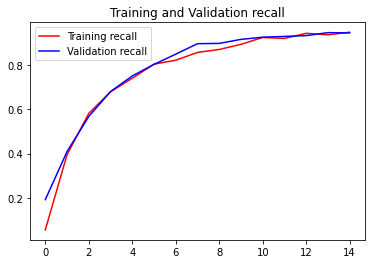

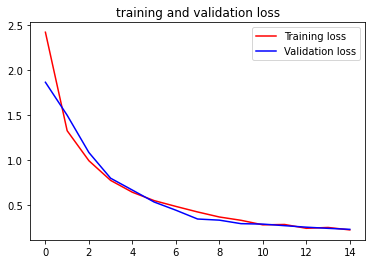

In [36]:
#history= [ history1, history2]
#for hist in history:
 #   perform_plot(hist)
  #  plt.figure()
perform_plot(history)

## save weight and bin file from the best model
this bin and wight file will used for next process in this project( tranfer learning)

In [ ]:
# save weight model
model.save_weights("best_model.h5")

## save models, convert to tf.lite, and save tf lite model 

export the save model

In [37]:

export_dir = 'saved_model/2'# edit jadi path drive
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/2/assets


INFO:tensorflow:Assets written to: saved_model/2/assets


In [ ]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/tools/saved_model_cli.py", line 1260, in main
    args.func(args)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/tools/saved_model_cli.py", line 745, in show
    _show_inputs_outputs(args.dir, args.tag_set, args.signature_def)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/tools/saved_model_cli.py", line 152, in _show_inputs_outputs
    tag_set)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/tools/saved_model_utils.py", line 113, in get_meta_graph_def
    saved_model = read_saved_model(saved_model_dir)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/tools/saved_model_utils.py", line 51, in read_saved_model
    raise IOError("SavedModel file does not exist at: %s" % saved_model_dir)
OSError: SavedModel file does not exist at: $RPS_SAVED_M

In [38]:
loaded = tf.saved_model.load(export_dir)
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_1_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_1_input')})
{'dense_1': TensorSpec(shape=(None, 15), dtype=tf.float32, name='dense_1')}


convert model to tensorflow lite

In [39]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
#converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [40]:
# save tensorflow lite model
#tflite_model_file = pathlib.Path('model.tflite')
#tflite_model_file.write_bytes(tflite_model)
tflite_model_file = 'converted_model_recall.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Test the TFLite Model Using the Python Interpreter

In [ ]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

In [ ]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = labels

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    print(type(predicted_label), type(true_label))
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 0 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

create fie for save labels

In [ ]:
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [ ]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass

## Prepare the Test Images for Download 

In [ ]:
!mkdir -p test_images

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')
loaded_model = keras.models.load_model('/content/ckpt/best3.h5')

In [ ]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))

In [ ]:
!ls test_images
!zip -qq rps_test_images.zip -r test_images/

In [ ]:
try:
    files.download('rps_test_images.zip')
except:
    pass